In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

pd.options.display.max_columns=None
pd.options.display.max_rows=None
pd.options.display.max_colwidth=1000000

# Australian Weather Prediction

The purpose of this project is to predict whether it will rain tomorrow or not, given independent variables (such as location, max/min temp, windspeed, evaporation, etc.) on a specific day

## 1. Load Data

In [2]:
#load dataset
df = pd.read_csv('weatherAUS.csv', parse_dates=['Date'])
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [3]:
#replace values under 'RainTomorrow' and 'RainToday'
#No : 0 and Yes : 1
df['RainTomorrow'].replace({'No':0, 'Yes':1}, inplace=True)
df['RainToday'].replace({'No':0, 'Yes':1}, inplace=True)
df.head(3)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,0.0,0
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,0.0,0
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0.0,0.0,0


## 2. Exploratory Data Analysis

Process of elimination and imputation using
1. Missing values
2. Information Value and WOE

### 2.1 Examine Missing Values

In [4]:
#total number of data points
print("total number of data points : " + str(len(df)))

total number of data points : 142193


In [5]:
print("no data : " + str(len(df[df['RainTomorrow'] == 0])))
print("yes data : " + str(len(df[df['RainTomorrow'] == 1])))

no data : 110316
yes data : 31877


In [6]:
print("percentage of 'RainTomorrow' from the whole dataset : " + str(31877 / (110316 + 31877)))

percentage of 'RainTomorrow' from the whole dataset : 0.22418121848473554


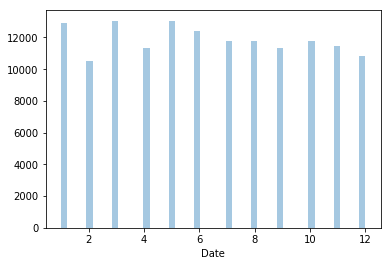

In [7]:
#distribution of months
sns.distplot(df['Date'].dt.month, kde=False)

* One assumption in dealing with this dataset is that **year** does not really affect whether it will rain tomorrow or not. However, we will take **month** into consideration.
* Month seems to be distributed evenly throughout the whole dataset

In [8]:
#look for missing values in each column
df.isnull().sum()

Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RISK_MM              0
RainTomorrow         0
dtype: int64

Average **WindSpeed3pm** and **WindSpeed9am** to make filling missing value later on easier

In [9]:
df['WindSpeedAvg'] = (df['WindSpeed3pm'] + df['WindSpeed9am']) / 2

**Missing Value Observation**<br>
We have a total of 142,193 observations (data points)

1. **Sunshine** : 67,816 out of 142,193 missing (nearly 47%)
2. **Evaporation** : 60,843 out of 142,193 missing missing (nearly 43%)
3. **Cloud3pm** : 57,094 out of 142,193 missing (nearly 40%)
4. **Cloud9am** : 53,657 out of 142,193 missing (nearly 38%)
5. **Pressure9am** : 14,014 out of 142,193 missing (nearly 10%)
6. **Pressure3pm** : 13,981 out of 142,193 missing (nearly 10%)
7. **WindDir9am** : 10,013 out of 142,193 missing (nearly 7%)
8. **WindDir3pm** : 3,778 out of 142,193 missing (nearly 2%)

### 2.2 Information Value and WOE Calculation

In [10]:
def calculate_iv(df, column, target, max_bin):
    bin_df = df[df[column].notnull()][[column, target]].copy()
    
    #if categorical
    if bin_df[column].dtype == 'object':
        bin_df = bin_df.groupby(column)[target].agg(['count', 'sum'])
    else:
        bin_df['bin'] = pd.qcut(bin_df[column].rank(method='first'), max_bin)
        bin_df = bin_df.groupby('bin')[target].agg(['count', 'sum'])
    
    bin_df.columns = ['total', 'abnormal']
    bin_df['normal'] = bin_df['total'] - bin_df['abnormal']
    bin_df['normal_dist'] = bin_df['normal'] / sum(bin_df['normal'])
    bin_df['abnormal_dist'] = bin_df['abnormal'] / sum(bin_df['abnormal'])
    bin_df['woe'] = np.log(bin_df['normal_dist'] / bin_df['abnormal_dist'])
    bin_df['iv'] = bin_df['woe'] * (bin_df['normal_dist'] - bin_df['abnormal_dist'])
    
    bin_df.replace([np.inf, -np.inf], 0, inplace=True)
    bin_df = bin_df[bin_df['total'] > 0]
    iv_val = sum(filter(lambda x: x != float('inf'), bin_df['iv']))
    
    return bin_df, column, iv_val

In [11]:
#calculate IV for the given features
columns = ['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am', 'Pressure9am', 'Pressure3pm', 'WindDir9am'
          , 'WindDir3pm', 'Location', 'WindGustDir', 'MaxTemp', 'MinTemp', 'RISK_MM', 'RainToday', 
          'WindSpeed9am', 'WindSpeed3pm', 'WindSpeedAvg', 'WindGustSpeed']
iv_record = {}

for col in columns:
    bin_df, column, iv_val = calculate_iv(df, col, 'RainTomorrow', 10)
    iv_record[col] = iv_val

import operator
candidates = sorted(iv_record.items(), key=operator.itemgetter(1), reverse=True)
display(candidates)

[('Sunshine', 1.3871867704518155),
 ('Cloud3pm', 0.9887073944152036),
 ('Cloud9am', 0.7121731751430987),
 ('RainToday', 0.4484383409870246),
 ('Pressure9am', 0.3465155263274764),
 ('WindGustSpeed', 0.29924903014217763),
 ('Pressure3pm', 0.2902225770540065),
 ('Location', 0.16210687977366678),
 ('MaxTemp', 0.15449355911735585),
 ('Evaporation', 0.11802518509918378),
 ('WindDir9am', 0.09801435562479796),
 ('WindGustDir', 0.0676479681745555),
 ('WindSpeedAvg', 0.0631002673547728),
 ('MinTemp', 0.05821765217612655),
 ('WindDir3pm', 0.05313562297763486),
 ('WindSpeed3pm', 0.05037603834863204),
 ('WindSpeed9am', 0.041675841616190965),
 ('RISK_MM', 0.0009978822699295321)]

* **Sunshine**, **Cloud3pm**, **Cloud9am** have very high Information Value and number of missing values, so we will get rid of these columns
* **WindDir9am**, **WindDir3pm**, **WindGustDir** have low Information Value and large missing values so we will get rid of these columns
* **Evaporation** also has high number of missing values, but its Information Value seems significant. Let's look into **Evaporation** later

In [12]:
#delete irrelevent columns
del df['Sunshine']
del df['Cloud3pm']
del df['Cloud9am']
del df['WindDir9am']
del df['WindDir3pm']
del df['WindGustDir']
del df['RISK_MM']
del df['WindSpeed3pm']
del df['WindSpeed9am']
del df['Evaporation']

* Whether it rained today or not has significant WOE, so we will discard any data points where **RainToday** is null

In [13]:
# drop null RainToday rows
df = df[~df['RainToday'].isnull()]

### 2.3 Split Training/Test Dataset

In [14]:
#parse year and month
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month

#delete Date and Year column
del df['Date']
del df['year']

In [15]:
#current columns
feature_col = list(df.columns)
feature_col.remove('Location')
feature_col.remove('month')
feature_col.remove('RainTomorrow')

feature_col

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'WindGustSpeed',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday',
 'WindSpeedAvg']

In [16]:
#drop rows where there are less than 10 non-null values
#with such large missing data in a given column, it will be very hard to impute the missing values
df.dropna(axis=0, subset=feature_col, thresh=10, inplace=True)

In [17]:
#check shape
df.shape

(135760, 15)

* Lost about **2,787** data points, which we can tolerate given the large number of dataset


In [18]:
df.isnull().sum()

Location            0
MinTemp            91
MaxTemp            52
Rainfall            0
WindGustSpeed    4678
Humidity9am       842
Humidity3pm      1451
Pressure9am      9644
Pressure3pm      9579
Temp9am            90
Temp3pm           668
RainToday           0
RainTomorrow        0
WindSpeedAvg      315
month               0
dtype: int64

In [19]:
#check the number of RainTomorrow is 1
len(df[df['RainTomorrow'] == 1])

29914

In [20]:
#set null and alt target values equal
null_train = df[df['RainTomorrow'] == 0].sample(29914)
alt_train = df[df['RainTomorrow'] == 1]

In [21]:
#check shape of null and alt datasets
print(null_train.shape)
print(alt_train.shape)

(29914, 15)
(29914, 15)


In [22]:
#concatenate
df = pd.concat([null_train, alt_train], axis=0)

In [23]:
#check new dataset shape
df.shape

(59828, 15)

In [24]:
#change month datatype
df['month'] = df['month'].astype('object')

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'RainTomorrow'],
                                                   df['RainTomorrow'], stratify=df['RainTomorrow'], test_size=0.3)

In [26]:
#check shapes
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(41879, 14)
(17949, 14)
(41879,)
(17949,)


In [27]:
#check positive to negative ratio in training dataset
sum(y_train) / len(y_train)

0.4999880608419494

In [28]:
#check positive to negative ratio in test dataset
sum(y_test) / len(y_test)

0.500027856705109

In [29]:
X_train.isnull().sum()

Location            0
MinTemp            27
MaxTemp            14
Rainfall            0
WindGustSpeed    1548
Humidity9am       291
Humidity3pm       467
Pressure9am      2911
Pressure3pm      2887
Temp9am            42
Temp3pm           202
RainToday           0
WindSpeedAvg      109
month               0
dtype: int64

### 2.4 Data Manipulation

In [30]:
X_train.isnull().sum()

Location            0
MinTemp            27
MaxTemp            14
Rainfall            0
WindGustSpeed    1548
Humidity9am       291
Humidity3pm       467
Pressure9am      2911
Pressure3pm      2887
Temp9am            42
Temp3pm           202
RainToday           0
WindSpeedAvg      109
month               0
dtype: int64

In [31]:
df_eda = X_train.dropna(how='any')
df_eda.shape

(36826, 14)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 <a list of 11 Text xticklabel objects>)

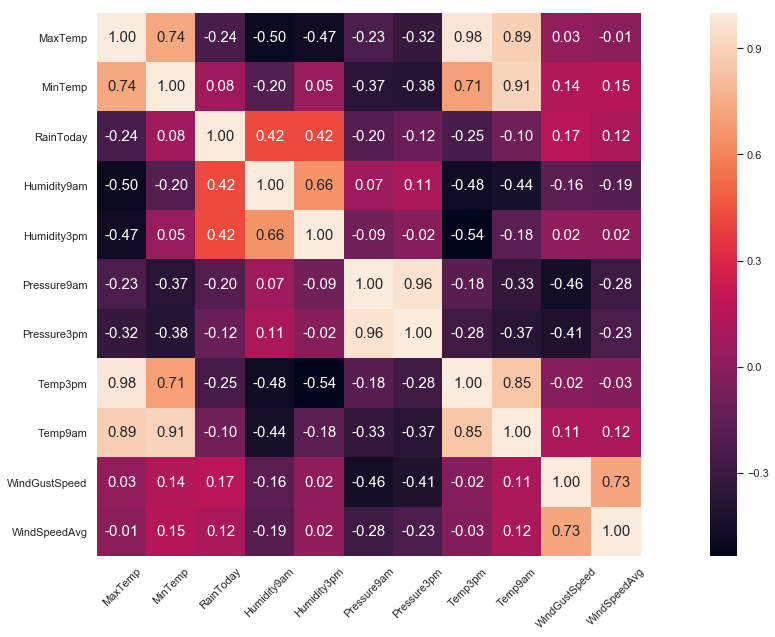

In [32]:
#correlation matrix
plt.figure(figsize = (25,10))
eda_columns = ['MaxTemp', 'MinTemp', 'RainToday', 'Humidity9am', 'Humidity3pm', 
               'Pressure9am', 'Pressure3pm', 'Temp3pm', 'Temp9am', 'WindGustSpeed', 'WindSpeedAvg']

corr_mat = np.corrcoef(df_eda[eda_columns].values.T)
sns.set(font_scale=1)
full_mat = sns.heatmap(corr_mat, cbar=True, annot=True, square=True,
                       fmt='.2f', annot_kws={'size': 15},
                       yticklabels=eda_columns, xticklabels=eda_columns)
plt.yticks(rotation=0)
plt.xticks(rotation=45)

In [33]:
def fill_missing1(training_df, filling_df, group_medium1, group_medium2, group_medium3, missing_feature):
    """
    Arguments:
    1. training_df : the dataset which is used to calculate missing values
    2. filling_df : the dataset which will be imputed using the values calculated through this function
    3. group_medium1 : the first medium through which we want to group the values
    4. group_medium2 : the second medium through which we want to group the values
    5. group_medium3 : the third medium through which we want to group the values
    5. missing_feature : the feature that we want to eventually calculate missing values on
    
    ex) fill_humidity_missing(X_train, X_train, 'RainToday', 'Location, 'month', 'Humidity') will do the following:
    group by Raintoday Location, and Month, in order, and calculate median Humidity rate from X_train dataset and
    fill missing Humidity values in X_train dataset
    """
    feature_dict = training_df.groupby([group_medium1, group_medium2, group_medium3])[missing_feature].agg(['median']).to_dict()['median']
    
    missing_index = filling_df.index[filling_df[missing_feature].isnull()].tolist()
    
    for row in missing_index:
        filling_df.loc[row, missing_feature] = feature_dict[(filling_df.loc[row, group_medium1], 
                                                             filling_df.loc[row, group_medium2],
                                                             filling_df.loc[row, group_medium3])]

In [34]:
fill_missing1(X_train, X_train, 'RainToday', 'Location', 'month', 'Humidity3pm')
fill_missing1(X_train, X_train, 'RainToday', 'Location', 'month', 'Humidity9am')
fill_missing1(X_train, X_train, 'RainToday', 'Location', 'month', 'MaxTemp')
fill_missing1(X_train, X_train, 'RainToday', 'Location', 'month', 'MinTemp')
fill_missing1(X_train, X_train, 'RainToday', 'Location', 'month', 'Temp9am')
fill_missing1(X_train, X_train, 'RainToday', 'Location', 'month', 'Temp3pm')

In [35]:
def fill_missing2(training_df, filling_df, group_medium1, group_medium2, missing_feature):
    """
    Arguments:
    1. training_df : the dataset which is used to calculate missing values
    2. filling_df : the dataset which will be imputed using the values calculated through this function
    3. group_medium1 : the first medium through which we want to group the values
    4. group_medium2 : the second medium through which we want to group the values
    5. group_medium3 : the third medium through which we want to group the values
    5. missing_feature : the feature that we want to eventually calculate missing values on
    
    ex) fill_humidity_missing(X_train, X_train, 'RainToday', 'Location, 'month', 'Humidity') will do the following:
    group by Raintoday Location, and Month, in order, and calculate median Humidity rate from X_train dataset and
    fill missing Humidity values in X_train dataset
    """
    feature_dict = training_df.groupby([group_medium1, group_medium2])[missing_feature].agg(['median']).to_dict()['median']
    
    missing_index = filling_df.index[filling_df[missing_feature].isnull()].tolist()
    
    for row in missing_index:
        filling_df.loc[row, missing_feature] = feature_dict[(filling_df.loc[row, group_medium1], 
                                                             filling_df.loc[row, group_medium2])]

In [36]:
fill_missing2(X_train, X_train, 'RainToday', 'month', 'Pressure3pm')
fill_missing2(X_train, X_train, 'RainToday', 'month', 'Pressure9am')

In [37]:
fill_missing2(X_train, X_train, 'RainToday', 'month', 'WindSpeedAvg')

In [38]:
fill_missing2(X_train, X_train, 'RainToday', 'month', 'Temp3pm')
fill_missing2(X_train, X_train, 'RainToday', 'month', 'Humidity3pm')

In [39]:
X_train.shape

(41879, 14)

In [40]:
X_train.isnull().sum()

Location            0
MinTemp             0
MaxTemp             0
Rainfall            0
WindGustSpeed    1548
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Temp9am             0
Temp3pm             0
RainToday           0
WindSpeedAvg        0
month               0
dtype: int64

In [41]:
def wind_gust_filling(training_df, filling_df):
    training_df['windgustbin'] = pd.cut(training_df['WindSpeedAvg'], 10)
    
    bin_df = training_df.groupby(['windgustbin'])['WindGustSpeed'].agg(['median'])
    
    missing_index = filling_df.index[filling_df['WindGustSpeed'].isnull()].tolist()
    
    for index in missing_index:
        for i in range(len(bin_df.index)):
            if filling_df.loc[index, 'WindSpeedAvg'] in bin_df.index[i]:
                filling_df.loc[index, 'WindGustSpeed'] = bin_df.iloc[i][0]

In [42]:
wind_gust_filling(X_train, X_train)

In [43]:
del X_train['windgustbin']

In [44]:
X_train.isnull().sum()

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
WindGustSpeed    0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Temp9am          0
Temp3pm          0
RainToday        0
WindSpeedAvg     0
month            0
dtype: int64

### 2.5 Add Dummy Variables

In [45]:
X_train.dtypes

Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
WindGustSpeed    float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Temp9am          float64
Temp3pm          float64
RainToday        float64
WindSpeedAvg     float64
month             object
dtype: object

In [46]:
#divide categorical and numerical features for scaling and making dummy varibles
num_features = []
cate_features = []
for feat in X_train.columns:
    if X_train[feat].dtype == 'object':
        cate_features.append(feat)
    elif feat != 'Target':
        num_features.append(feat)

In [47]:
cate_features

['Location', 'month']

In [48]:
train_cate_features = pd.get_dummies(X_train[cate_features])

In [49]:
train_cate_features.head()

,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
103554,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
37344,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
49670,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
31201,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
122784,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


### 2.6 Feature Scaling

In [50]:
from sklearn.preprocessing import MinMaxScaler

In [51]:
scaler = MinMaxScaler()
scaler.fit(X_train[num_features])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [52]:
train_scaled_num_features = scaler.transform(X_train[num_features])

In [53]:
#combine categorical and numberical features
train_x = np.c_[train_scaled_num_features, train_cate_features]

In [54]:
print(train_x.shape)
print(y_train.shape)

(41879, 72)
(41879,)


## 3. Modeling

In [55]:
from sklearn.linear_model import LogisticRegression

In [56]:
logistic = LogisticRegression(random_state=42)

In [57]:
from sklearn.model_selection import cross_val_score
cross_val_score(logistic, train_x, y_train, cv=3, scoring='accuracy')

array([0.79040115, 0.78230659, 0.77827925])

In [58]:
logistic.fit(train_x, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

### 4. Test Dataset

In [59]:
X_test.isnull().sum()

Location            0
MinTemp            11
MaxTemp             7
Rainfall            0
WindGustSpeed     718
Humidity9am       142
Humidity3pm       202
Pressure9am      1239
Pressure3pm      1240
Temp9am            11
Temp3pm            75
RainToday           0
WindSpeedAvg       49
month               0
dtype: int64

In [60]:
fill_missing1(X_train, X_test, 'RainToday', 'Location', 'month', 'Humidity3pm')
fill_missing1(X_train, X_test, 'RainToday', 'Location', 'month', 'Humidity9am')
fill_missing1(X_train, X_test, 'RainToday', 'Location', 'month', 'MaxTemp')
fill_missing1(X_train, X_test, 'RainToday', 'Location', 'month', 'MinTemp')
fill_missing1(X_train, X_test, 'RainToday', 'Location', 'month', 'Temp9am')
fill_missing1(X_train, X_test, 'RainToday', 'Location', 'month', 'Temp3pm')

In [61]:
fill_missing2(X_train, X_test, 'RainToday', 'month', 'Pressure3pm')
fill_missing2(X_train, X_test, 'RainToday', 'month', 'Pressure9am')

In [62]:
fill_missing2(X_train, X_test, 'RainToday', 'month', 'WindSpeedAvg')

In [65]:
wind_gust_filling(X_train, X_test)

In [67]:
X_test.isnull().sum()

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
WindGustSpeed    0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Temp9am          0
Temp3pm          0
RainToday        0
WindSpeedAvg     0
month            0
dtype: int64

In [68]:
X_test.dtypes

Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
WindGustSpeed    float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Temp9am          float64
Temp3pm          float64
RainToday        float64
WindSpeedAvg     float64
month             object
dtype: object

In [71]:
#divide categorical and numerical features for scaling and making dummy varibles
num_features_test = []
cate_features_test = []
for feat in X_test.columns:
    if X_test[feat].dtype == 'object':
        cate_features_test.append(feat)
    elif feat != 'Target':
        num_features_test.append(feat)

In [72]:
cate_features_test

['Location', 'month']

In [73]:
test_cate_features = pd.get_dummies(X_test[cate_features_test])

In [74]:
test_cate_features.head()

,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
102560,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
35156,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
136201,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
10295,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
52301,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [75]:
test_scaled_num_features = scaler.transform(X_test[num_features_test])

In [78]:
test_x = np.c_[test_scaled_num_features, test_cate_features]

In [79]:
print(test_x.shape)
print(y_test.shape)

(17949, 72)
(17949,)


In [80]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [81]:
accuracy = accuracy_score(logistic.predict(test_x), y_test)
print('Accuracy :', accuracy)

Accuracy : 0.7884561814028637


In [83]:
print(classification_report(y_test, logistic.predict(test_x)))

              precision    recall  f1-score   support

           0       0.78      0.81      0.79      8974
           1       0.80      0.77      0.78      8975

   micro avg       0.79      0.79      0.79     17949
   macro avg       0.79      0.79      0.79     17949
weighted avg       0.79      0.79      0.79     17949



In [84]:
pd.crosstab(logistic.predict(test_x), y_test, 
            rownames=['Predict'], colnames=['Actual'], margins=True)

Actual,0,1,All
Predict,,,
0,7233,2056,9289
1,1741,6919,8660
All,8974,8975,17949
